In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Lets Drop one feature and find whether the accuracy score is decreasing or not**

In [3]:
import pandas as pd
Ml_Train=pd.read_csv('/kaggle/input/ml-train-dataset/ML_Train_Data.csv')
Ml_Train.head()

,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,Day,PartOfDay,IncidentGrade
0,7,6,InitialAccess,T1078;T1078.004,Ip,Related,4,Morning,TruePositive
1,58,43,Exfiltration,T1041,User,Impacted,14,Early Morning,FalsePositive
2,423,298,InitialAccess,T1189,Url,Related,13,Early Morning,FalsePositive
3,2,2,CommandAndControl,T1046;T1071;T1210,Url,Related,10,Evening,BenignPositive
4,9,74,Execution,T1559;T1106;T1059.005,User,Impacted,15,Early Morning,TruePositive


**Now Lets Do the Frequency Encoding**

In [4]:
import pandas as pd
import pickle

# Categorical columns to be frequency encoded
frequency_encoding_columns = ['Category', 'MitreTechniques', 'EntityType', 'EvidenceRole']

# Frequency Encoding for ML_Train
category_mappings = {}

for column in frequency_encoding_columns:
    # Get frequency distribution based on ML_Train data
    frequency_map = Ml_Train[column].value_counts(normalize=True)
    
    # Map frequencies to a new column in ML_Train
    Ml_Train[column + '_freq'] = Ml_Train[column].map(frequency_map)
    
    # Store the frequency mappings to apply on ML_Test later
    category_mappings[column] = frequency_map.to_dict()

with open(r'Freq_enco_mapping.pkl', 'wb') as f:
    pickle.dump(category_mappings, f)

print("Frequency encoding applied to ML_Train and ML_Test, and mappings saved to pickle file!")

Frequency encoding applied to ML_Train and ML_Test, and mappings saved to pickle file!


**Now Similarly do the LabelEncoding for the Ordinal Categorical Values**

In [5]:
# Import label encoder 
from sklearn import preprocessing 
a=['PartOfDay','IncidentGrade']
label_encoder = preprocessing.LabelEncoder() 
for i in a:
    Ml_Train[i]= label_encoder.fit_transform(Ml_Train[i]) 
    print(Ml_Train[i].unique())

[3 1 2 0 4]
[2 1 0]


**Now Lets Drop and Rename the Old Column names and Column**

In [6]:
Ml_Train.drop(['Category','MitreTechniques','EntityType','EvidenceRole'],axis=1,inplace = True)

In [7]:
Ml_Train.rename(columns={'Category_freq':'Category', 
                         'MitreTechniques_freq':'MitreTechniques', 
                         'EntityType_freq':'EntityType', 
                         'EvidenceRole_freq':'EvidenceRole'}, inplace=True)


In [8]:
Features=Ml_Train[['DetectorId','AlertTitle','Category','MitreTechniques','EntityType','EvidenceRole','Day','PartOfDay']]
Features.head()

,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,Day,PartOfDay
0,7,6,0.452709,0.259097,0.230436,0.550274,4,3
1,58,43,0.163832,0.161817,0.199259,0.449726,14,1
2,423,298,0.452709,0.000233,0.072112,0.550274,13,1
3,2,2,0.087224,0.075662,0.072112,0.550274,10,2
4,9,74,0.028186,0.021806,0.199259,0.449726,15,1


In [9]:
Target=Ml_Train['IncidentGrade']
Target

0          2
1          1
2          1
3          0
4          2
          ..
9465492    2
9465493    0
9465494    0
9465495    0
9465496    0
Name: IncidentGrade, Length: 9465497, dtype: int64

**Spliting the Dataset for test and train**

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Features,Target, test_size=0.3,random_state=42,stratify=Target)

In [68]:
X_train.head()

,OrgId,DetectorId,AlertTitle,Day,PartOfDay,Category,MitreTechniques,EntityType
3618427,1,0,0,5,4,0.452709,0.259097,0.067462
7481599,37,70,2961,6,0,0.163832,0.161817,0.123940
8241606,25,30,3109,4,0,0.163832,0.161817,0.123940
6467893,54,179,24,15,1,0.031698,0.003335,0.230436
8480286,190,6,5,12,3,0.452709,0.069335,0.230436


**Now Standardizing the Values**

In [11]:
from sklearn.preprocessing import StandardScaler
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Let's inspect whether all the class in the dataset have a equally present**

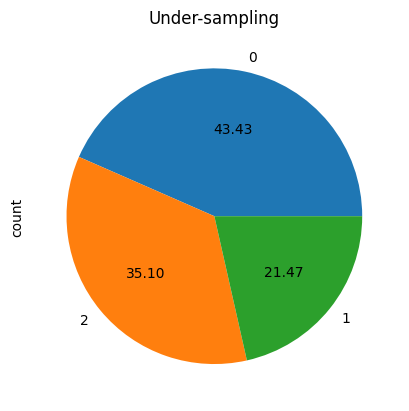

In [12]:
y_train.value_counts()

ax = y_train.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

In [13]:
!pip install imbalanced-learn

**Seems Like the 0th Class have more number of data when compare to the other Class let's do the undersampling**


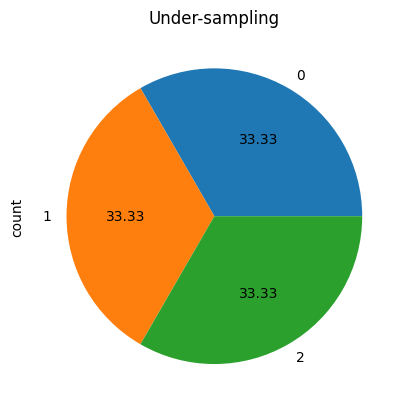

In [14]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler() # Numerical value
# rus = RandomUnderSampler(sampling_strategy="not minority") # String
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)


ax = y_train_rus.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

**Let Train the 3 model since other model and not performing well Check Version 1 Notebook for Clearunderstanding and Check which model Performs well and based on the Best performing model lets do the Other Process**

In [15]:
# Import required libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from xgboost import XGBClassifier

# Initialize the models
#model_lr = LogisticRegression(random_state=42)
model_dt = DecisionTreeClassifier(random_state=42)
model_rf = RandomForestClassifier(random_state=42, n_estimators=100)


# Fit each model
#model_lr.fit(X_train_rus, y_train_rus)
model_dt.fit(X_train_rus, y_train_rus)
model_rf.fit(X_train_rus, y_train_rus)



RandomForestClassifier(random_state=42)

In [16]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(X_train_rus, y_train_rus)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

**Now I have Trained the Model let's Evaluate the Model and check whether My model can able to Generalize well or not**

In [17]:
# Import required metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# List of models and their names
models = {
    #"Logistic Regression": model_lr,
    "Decision Tree": model_dt,
    "Random Forest": model_rf,
    #"Gradient Boosting": model_gb,
    #"K-Nearest Neighbors": model_knn,
    #"SGD Classifier": model_sgd,
}" ""XGBoost": model_xgb
}

# Loop through each model and evaluate
for name, model in models.items():
    print(f"Evaluating {name}:")
    
    # Predict on the test set 
    y_pred = model.predict(X_test_scaled)
    
    # Accuracy Score
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\n" + "="*60 + "\n")


Evaluating Decision Tree:
Accuracy: 0.8281
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86   1233246
           1       0.77      0.77      0.77    609590
           2       0.85      0.79      0.82    996814

    accuracy                           0.83   2839650
   macro avg       0.82      0.82      0.82   2839650
weighted avg       0.83      0.83      0.83   2839650

Confusion Matrix:
[[1096216   70918   66112]
 [  68916  468338   72336]
 [ 140075   69767  786972]]


Evaluating Random Forest:
Accuracy: 0.8219
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86   1233246
           1       0.76      0.76      0.76    609590
           2       0.85      0.78      0.81    996814

    accuracy                           0.82   2839650
   macro avg       0.81      0.81      0.81   2839650
weighted avg       0.82      0.82      0.82   2839650

Conf

EvenThough I have dropped the least important feature The Model performanece is not increased Much so What I will do is I will Include One feature(Based On EDA insight) and Check Whether the Model performance is increasing or not 

# Version 2

**LoadinG the Train Data**

In [18]:
import pandas as pd
Ml_Train=pd.read_csv('/kaggle/input/eda-train/Cleaned_Train.csv')
Ml_Train.head()

,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,EntityType,EvidenceRole,...,Registry_Info,Application_Info,OS_Info,Location_Info,Device_Ip,File_Info,Day,Month,Year,PartOfDay
0,0,612,123247,7,6,InitialAccess,T1078;T1078.004,TruePositive,Ip,Related,...,1631 635 860,2251 3421,5 66,6 3 31,27 160396,289573 117668,4,6,2024,Morning
1,88,326,210035,58,43,Exfiltration,T1041,FalsePositive,User,Impacted,...,1631 635 860,2251 3421,5 66,1445 10630 242,360606 160396,289573 117668,14,6,2024,Early Morning
2,809,58352,712507,423,298,InitialAccess,T1189,FalsePositive,Url,Related,...,1631 635 860,2251 3421,5 66,1445 10630 242,360606 68652,289573 117668,13,6,2024,Early Morning
3,92,32992,774301,2,2,CommandAndControl,T1046;T1071;T1210,BenignPositive,Url,Related,...,1631 635 860,2251 3421,5 66,1445 10630 242,360606 13,289573 117668,10,6,2024,Evening
4,148,4359,188041,9,74,Execution,T1559;T1106;T1059.005,TruePositive,User,Impacted,...,1631 635 860,2251 3421,5 66,1445 10630 242,360606 160396,289573 117668,15,6,2024,Early Morning


**Loading the Test Data**

In [19]:
import pandas as pd
Ml_Test=pd.read_csv('/kaggle/input/v2-test/Cleaned_Test.csv')
Ml_Test.head()

,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,EntityType,EvidenceRole,...,Registry_Info,Application_Info,OS_Info,Location_Info,Device_Ip,File_Info,Day,Month,Year,PartOfDay
0,657,11767,87199,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,User,Impacted,...,1631 635 860,2251 3421,5 66,1445 10630 242,360606 160396,289573 117668,4,6,2024,Night
1,3,91158,632273,2,2,CommandAndControl,T1046;T1030;T1071;T1071.001,BenignPositive,Machine,Impacted,...,1631 635 860,2251 3421,0 0,1445 10630 242,360606 160396,289573 117668,3,6,2024,Afternoon
2,145,32247,131719,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,Process,Related,...,1631 635 860,2251 3421,5 66,1445 10630 242,360606 160396,14 22,8,6,2024,Early Morning
3,222,15294,917686,0,0,InitialAccess,T1078;T1078.004,FalsePositive,CloudLogonSession,Related,...,1631 635 860,2251 3421,5 66,1445 10630 242,360606 160396,289573 117668,12,6,2024,Afternoon
4,363,7615,5944,27,18,Discovery,T1087;T1087.002,BenignPositive,User,Impacted,...,1631 635 860,2251 3421,5 66,1445 10630 242,360606 160396,289573 117668,6,6,2024,Evening


**Picking Up only the Required Columns for ML Training**

In [20]:
Ml_Train=Ml_Train[['OrgId','DetectorId','AlertTitle','Category','MitreTechniques','EntityType','Day','PartOfDay','IncidentGrade']]
Ml_Train.head()

,OrgId,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,Day,PartOfDay,IncidentGrade
0,0,7,6,InitialAccess,T1078;T1078.004,Ip,4,Morning,TruePositive
1,88,58,43,Exfiltration,T1041,User,14,Early Morning,FalsePositive
2,809,423,298,InitialAccess,T1189,Url,13,Early Morning,FalsePositive
3,92,2,2,CommandAndControl,T1046;T1071;T1210,Url,10,Evening,BenignPositive
4,148,9,74,Execution,T1559;T1106;T1059.005,User,15,Early Morning,TruePositive


**Picking Up only the Required Columns for ML EValuation**

In [23]:
Ml_Test=Ml_Test[['OrgId','DetectorId','AlertTitle','Category','MitreTechniques','EntityType','Day','PartOfDay','IncidentGrade']]
Ml_Test.head()

,OrgId,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,Day,PartOfDay,IncidentGrade
0,657,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,User,4,Night,BenignPositive
1,3,2,2,CommandAndControl,T1046;T1030;T1071;T1071.001,Machine,3,Afternoon,BenignPositive
2,145,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,Process,8,Early Morning,BenignPositive
3,222,0,0,InitialAccess,T1078;T1078.004,CloudLogonSession,12,Afternoon,FalsePositive
4,363,27,18,Discovery,T1087;T1087.002,User,6,Evening,BenignPositive


**Some Data in the Test Data is not Present in the Train Data So Droping the unwanted Data from the TestData**


In [24]:
import pandas as pd

# Step 1: Identify new (unseen) values in Ml_Test['MitreTechniques']
# Values in Ml_Test['MitreTechniques'] that are not in Ml_Train['MitreTechniques']
new_values = Ml_Test['MitreTechniques'][~Ml_Test['MitreTechniques'].isin(Ml_Train['MitreTechniques'].unique())]

# Step 2: Calculate how many rows have new (unseen) values
num_new_values = len(new_values)
print(f"Number of rows in Ml_Test['MitreTechniques'] with new (unseen) values: {num_new_values}")

# Step 3: Drop rows with new (unseen) values from Ml_Test
Ml_Test_cleaned = Ml_Test[~Ml_Test['MitreTechniques'].isin(new_values)]

# Optionally, you can directly update the original Ml_Test by dropping the rows
Ml_Test.drop(Ml_Test[Ml_Test['MitreTechniques'].isin(new_values)].index, inplace=True)

# Print the updated test dataframe and its size
print(f"Rows after dropping new values: {len(Ml_Test)}")


Number of rows in Ml_Test['MitreTechniques'] with new (unseen) values: 1951
Rows after dropping new values: 4146041


**Now Let's Do the Encoding**


> Since in 4 Columns there are more unique Categorical values and that are not ordinal as well so doing the Label encoding won't be a sutiable and model can able to miscalculate that there is a rank based relation between the category present in the Columns And doing the One hot encoding also a effective or the reliable solution it will Increase the Dimension of the Data so I will Go with the Frequency Encoding

In [26]:
import pandas as pd
import pickle

# Categorical columns to be frequency encoded
frequency_encoding_columns = ['Category', 'MitreTechniques', 'EntityType']

# Frequency Encoding for ML_Train
category_mappings = {}

for column in frequency_encoding_columns:
    # Get frequency distribution based on ML_Train data
    frequency_map = Ml_Train[column].value_counts(normalize=True)
    
    # Map frequencies to a new column in ML_Train
    Ml_Train[column + '_freq'] = Ml_Train[column].map(frequency_map)
    
    # Store the frequency mappings to apply on ML_Test later
    category_mappings[column] = frequency_map.to_dict()

# Drop the original categorical columns if needed from ML_Train
# Ml_Train.drop(columns=frequency_encoding_columns, inplace=True)

# Now, apply the same mappings to ML_Test
for column in frequency_encoding_columns:
    # Use the frequency mappings calculated from ML_Train
    freq_col_name = column + '_freq'
    Ml_Test[freq_col_name] = Ml_Test[column].map(category_mappings[column])
    
    # Fill any NaN values in case a category in ML_Test is not found in ML_Train
    Ml_Test[freq_col_name] = Ml_Test[freq_col_name].fillna(0)

# Drop the original categorical columns if needed from ML_Test
# Ml_Test.drop(columns=frequency_encoding_columns, inplace=True)

# save the mappings to a pickle file for future use
with open(r'Freq_enco_mapping.pkl', 'wb') as f:
    pickle.dump(category_mappings, f)

print("Frequency encoding applied to ML_Train and ML_Test, and mappings saved to pickle file!")

Frequency encoding applied to ML_Train and ML_Test, and mappings saved to pickle file!


In [28]:
Ml_Train.head()

,OrgId,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,Day,PartOfDay,IncidentGrade,Category_freq,MitreTechniques_freq,EntityType_freq
0,0,7,6,InitialAccess,T1078;T1078.004,Ip,4,Morning,TruePositive,0.452709,0.259097,0.230436
1,88,58,43,Exfiltration,T1041,User,14,Early Morning,FalsePositive,0.163832,0.161817,0.199259
2,809,423,298,InitialAccess,T1189,Url,13,Early Morning,FalsePositive,0.452709,0.000233,0.072112
3,92,2,2,CommandAndControl,T1046;T1071;T1210,Url,10,Evening,BenignPositive,0.087224,0.075662,0.072112
4,148,9,74,Execution,T1559;T1106;T1059.005,User,15,Early Morning,TruePositive,0.028186,0.021806,0.199259


**There some Ordinal Relationship between the category present in the PartofDay And the IncidentGrade So I will do a Label Encoding for those Columns**

In [29]:
Ml_Test.head()

,OrgId,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,Day,PartOfDay,IncidentGrade,Category_freq,MitreTechniques_freq,EntityType_freq
0,657,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,User,4,Night,BenignPositive,0.004352,0.000008,0.199259
1,3,2,2,CommandAndControl,T1046;T1030;T1071;T1071.001,Machine,3,Afternoon,BenignPositive,0.087224,0.003039,0.073704
3,222,0,0,InitialAccess,T1078;T1078.004,CloudLogonSession,12,Afternoon,FalsePositive,0.452709,0.259097,0.022437
4,363,27,18,Discovery,T1087;T1087.002,User,6,Evening,BenignPositive,0.013523,0.007330,0.199259
5,0,0,0,InitialAccess,T1078;T1078.004,User,6,Morning,TruePositive,0.452709,0.259097,0.199259


**There some Ordinal Relationship between the category present in the PartofDay And the IncidentGrade So I will do a Label Encoding for those Columns**

In [30]:
# Import label encoder 
from sklearn import preprocessing 
a=['PartOfDay','IncidentGrade']
label_encoder = preprocessing.LabelEncoder() 
for i in a:
    Ml_Train[i]= label_encoder.fit_transform(Ml_Train[i]) 
    print(Ml_Train[i].unique())
    Ml_Test[i]= label_encoder.transform(Ml_Test[i]) 
    print(Ml_Test[i].unique())

[3 1 2 0 4]
[4 0 2 3 1]
[2 1 0]
[0 1 2]


**Now the Rename and Drop the old Columns for better understand and Model training**


**Dropping the Old Columns**

In [32]:
Ml_Train.drop(['Category','MitreTechniques','EntityType'],axis=1,inplace = True)

In [34]:
Ml_Test.drop(['Category','MitreTechniques','EntityType'],axis=1,inplace = True)

**Renaming the columns with the old names For Better Understanding**


In [35]:
Ml_Train.rename(columns={'Category_freq':'Category', 
                         'MitreTechniques_freq':'MitreTechniques', 
                         'EntityType_freq':'EntityType'}, inplace=True)


In [36]:
Ml_Test.rename(columns={'Category_freq':'Category', 
                         'MitreTechniques_freq':'MitreTechniques', 
                         'EntityType_freq':'EntityType'}, inplace=True)


In [37]:
Ml_Train.head()

,OrgId,DetectorId,AlertTitle,Day,PartOfDay,IncidentGrade,Category,MitreTechniques,EntityType
0,0,7,6,4,3,2,0.452709,0.259097,0.230436
1,88,58,43,14,1,1,0.163832,0.161817,0.199259
2,809,423,298,13,1,1,0.452709,0.000233,0.072112
3,92,2,2,10,2,0,0.087224,0.075662,0.072112
4,148,9,74,15,1,2,0.028186,0.021806,0.199259


In [38]:
Ml_Test.head()

,OrgId,DetectorId,AlertTitle,Day,PartOfDay,IncidentGrade,Category,MitreTechniques,EntityType
0,657,524,563,4,4,0,0.004352,0.000008,0.199259
1,3,2,2,3,0,0,0.087224,0.003039,0.073704
3,222,0,0,12,0,1,0.452709,0.259097,0.022437
4,363,27,18,6,2,0,0.013523,0.007330,0.199259
5,0,0,0,6,3,2,0.452709,0.259097,0.199259


**Exporting the Encoded Test Data**

In [39]:
Ml_Test.to_csv("ML_Test_fre_encode_V2.csv",index=False)

**Seggregate the Features and Targets**

In [40]:
Features=Ml_Train.drop('IncidentGrade',axis=1)
Features.head()

,OrgId,DetectorId,AlertTitle,Day,PartOfDay,Category,MitreTechniques,EntityType
0,0,7,6,4,3,0.452709,0.259097,0.230436
1,88,58,43,14,1,0.163832,0.161817,0.199259
2,809,423,298,13,1,0.452709,0.000233,0.072112
3,92,2,2,10,2,0.087224,0.075662,0.072112
4,148,9,74,15,1,0.028186,0.021806,0.199259


In [41]:
Target=Ml_Train['IncidentGrade']
Target

0          2
1          1
2          1
3          0
4          2
          ..
9465492    2
9465493    0
9465494    0
9465495    0
9465496    0
Name: IncidentGrade, Length: 9465497, dtype: int64

**Spliting the Dataset for test and train**

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Features,Target, test_size=0.3,random_state=42,stratify=Target)

**Strandardizing or Normalizing the Features since the columns are in different ranges**

In [43]:
from sklearn.preprocessing import StandardScaler
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Saving or Pickling the StandardScaler Knowledge Since it will be Used for Scale the Test Data**

In [44]:
import pickle

# Save the model to a file using Pickle
with open('Scale_V2.pkl', 'wb') as file:
   pickle.dump(scaler, file)

**Let's inspect whether all the class in the dataset have a equally present**

**Seems Like the 0th Class have more number of data when compare to the other Class let's do the undersampling**

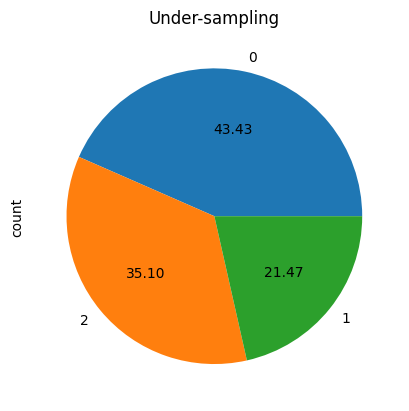

In [45]:
y_train.value_counts()

ax = y_train.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

In [ ]:
!pip install imbalanced-learn

**Doing the Random UnderSampling**

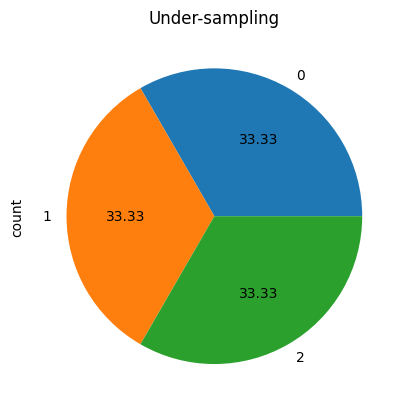

In [46]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler() # Numerical value
# rus = RandomUnderSampler(sampling_strategy="not minority") # String
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)


ax = y_train_rus.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

**Let Train the 3 model since other model and not performing well Check Version 1 Notebook for Clearunderstanding and Check which model Performs well and based on the Best performing model lets do the Other Process**

In [47]:
# Import required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

# Initialize the models
#model_lr = LogisticRegression(random_state=42)
model_dt = DecisionTreeClassifier(random_state=42)
model_rf = RandomForestClassifier(random_state=42, n_estimators=100)
model_xgb = XGBClassifier(random_state=42)

# Fit each model
#model_lr.fit(X_train_rus, y_train_rus)
model_dt.fit(X_train_rus, y_train_rus)
model_rf.fit(X_train_rus, y_train_rus)
model_xgb.fit(X_train_rus, y_train_rus)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

**Now I have Trained the Model let's Evaluate the Model and check whether My model can able to Generalize well or not**


In [48]:
# Import required metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# List of models and their names
models = {
    #"Logistic Regression": model_lr,
    "Decision Tree": model_dt,
    "Random Forest": model_rf,
    #"Gradient Boosting": model_gb,
    #"K-Nearest Neighbors": model_knn,
    #"SGD Classifier": model_sgd,
    "XGBoost": model_xgb
}

# Loop through each model and evaluate
for name, model in models.items():
    print(f"Evaluating {name}:")
    
    # Predict on the test set 
    y_pred = model.predict(X_test_scaled)
    
    # Accuracy Score
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\n" + "="*60 + "\n")

Evaluating Decision Tree:
Accuracy: 0.9810
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99   1233246
           1       0.96      0.98      0.97    609590
           2       0.98      0.98      0.98    996814

    accuracy                           0.98   2839650
   macro avg       0.98      0.98      0.98   2839650
weighted avg       0.98      0.98      0.98   2839650

Confusion Matrix:
[[1207805   13702   11739]
 [   5080  599533    4977]
 [   5599   12782  978433]]


Evaluating Random Forest:
Accuracy: 0.9664
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97   1233246
           1       0.93      0.97      0.95    609590
           2       0.97      0.97      0.97    996814

    accuracy                           0.97   2839650
   macro avg       0.96      0.97      0.96   2839650
weighted avg       0.97      0.97      0.97   2839650

Conf

**the Model such as Randam Forest, Decision Tree, XGBoost  well so I will Take This Model for the furthur Processs**

In [49]:
# Import required metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# List of models and their names
models = {
    #"Logistic Regression": model_lr,
    "Decision Tree": model_dt,
    "Random Forest": model_rf,
    #"Gradient Boosting": model_gb,
    #"K-Nearest Neighbors": model_knn,
    #"SGD Classifier": model_sgd,
    "XGBoost": model_xgb
}

# Loop through each model and evaluate
for name, model in models.items():
    print(f"Validataing {name}:")
    
    # Predict on the train set 
    y_pred_val = model.predict(X_train_rus)
    
    # Accuracy Score
    acc = accuracy_score(y_train_rus,y_pred_val)
    print(f"Accuracy: {acc:.4f}")
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_train_rus,y_pred_val))
    
    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_train_rus,y_pred_val))
    
    print("\n" + "="*60 + "\n")


Validataing Decision Tree:
Accuracy: 0.9865
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99   1422377
           1       0.98      0.99      0.99   1422377
           2       0.99      0.99      0.99   1422377

    accuracy                           0.99   4267131
   macro avg       0.99      0.99      0.99   4267131
weighted avg       0.99      0.99      0.99   4267131

Confusion Matrix:
[[1400092   11437   10848]
 [   8349 1406380    7648]
 [   5413   13987 1402977]]


Validataing Random Forest:
Accuracy: 0.9865
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99   1422377
           1       0.98      0.99      0.99   1422377
           2       0.99      0.99      0.99   1422377

    accuracy                           0.99   4267131
   macro avg       0.99      0.99      0.99   4267131
weighted avg       0.99      0.99      0.99   4267131

Co

**Let Check the Future importance**

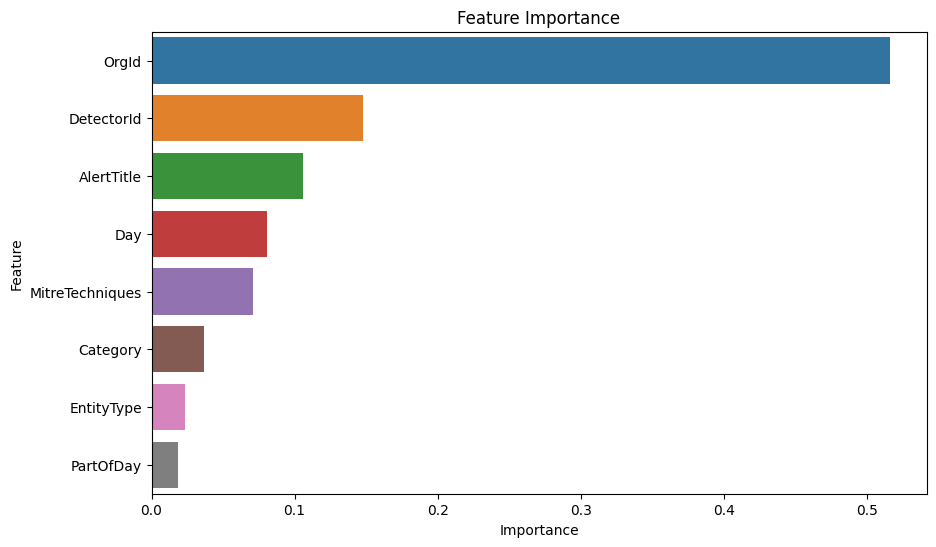

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor


feature_importance = model_rf.feature_importances_

features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# Sorting the features by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Lets Compare the Three model**

In [52]:
Model=['Decision_Tree','Random_Forest','Xtream_GB']
R2_Evalu=[98.10,96.64,91.11]
R2_validation=[98.65,98.65,91.48]

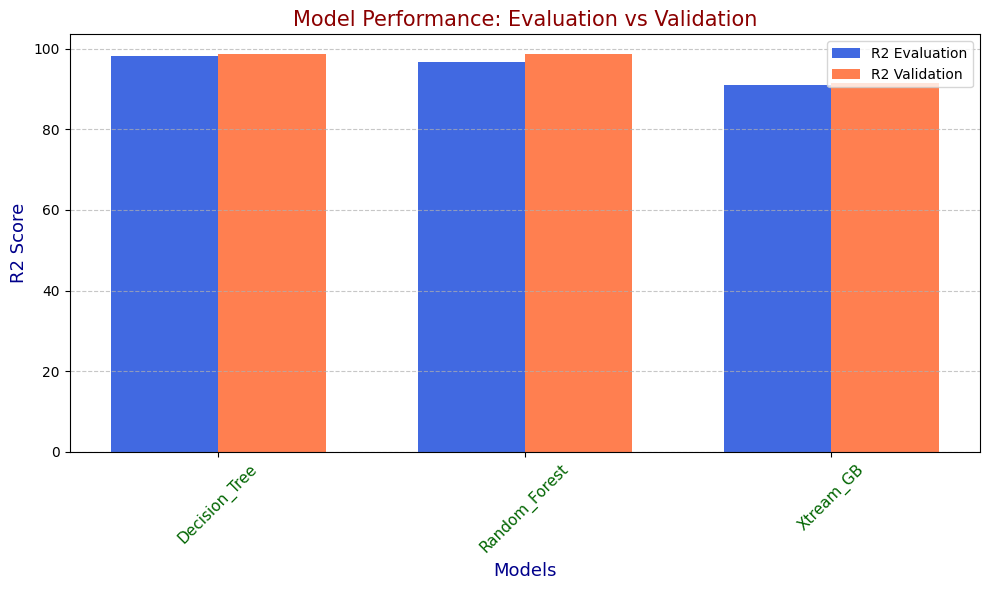

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plotting the grouped bar chart
bar_width = 0.35
index = np.arange(len(Model))

plt.bar(index, R2_Evalu, width=bar_width, color='royalblue', label='R2 Evaluation')
plt.bar(index + bar_width, R2_validation, width=bar_width, color='coral', label='R2 Validation')

# Labeling the chart
plt.xlabel('Models', fontsize=13, color='darkblue')
plt.ylabel('R2 Score', fontsize=13, color='darkblue')
plt.title('Model Performance: Evaluation vs Validation', fontsize=15, color='darkred')

# Adding model names
plt.xticks(index + bar_width / 2, Model, rotation=45, fontsize=11, color='darkgreen')

# Adding a legend and grid
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


**Now Pickle the Three Model and Check the performance in Unseen Test Data**

In [54]:
import pickle

# Save the model to a file using Pickle
with open('Random_forest_model_V2.pkl', 'wb') as file:
   pickle.dump(model_rf, file)

In [55]:
import pickle


# Save the model to a file using Pickle
with open('DecisionTree_model_v2.pkl', 'wb') as file:
   pickle.dump(model_dt, file)

In [56]:
import pickle

# Save the model to a file using Pickle
with open('XtreameGB_model_V2.pkl', 'wb') as file:
   pickle.dump(model_xgb, file)

# ***Now Let's test it in the actuall Test Data***

**Loading the Model**

In [57]:
import pandas as pd
Ml_evalu=pd.read_csv('/kaggle/input/final-evaluation-v2/ML_Test_fre_encode_V2.csv')
Ml_evalu.head()

,OrgId,DetectorId,AlertTitle,Day,PartOfDay,IncidentGrade,Category,MitreTechniques,EntityType
0,657,524,563,4,4,0,0.004352,0.000008,0.199259
1,3,2,2,3,0,0,0.087224,0.003039,0.073704
2,222,0,0,12,0,1,0.452709,0.259097,0.022437
3,363,27,18,6,2,0,0.013523,0.007330,0.199259
4,0,0,0,6,3,2,0.452709,0.259097,0.199259


In [58]:
Ml_evalu.head()

,OrgId,DetectorId,AlertTitle,Day,PartOfDay,IncidentGrade,Category,MitreTechniques,EntityType
0,657,524,563,4,4,0,0.004352,0.000008,0.199259
1,3,2,2,3,0,0,0.087224,0.003039,0.073704
2,222,0,0,12,0,1,0.452709,0.259097,0.022437
3,363,27,18,6,2,0,0.013523,0.007330,0.199259
4,0,0,0,6,3,2,0.452709,0.259097,0.199259


**Loading the pickled StandardScaler for Doing the Standardization**


In [60]:
import pickle
import pandas as pd

# Load the scaler
with open('/kaggle/input/final-evaluation-v2/Scale_V2.pkl', 'rb') as f:
    scaler = pickle.load(f)

**Splitting the Target And Feature**

In [62]:
Target=Ml_evalu['IncidentGrade']

In [70]:
features =Ml_evalu[['OrgId','DetectorId','AlertTitle','Day','PartOfDay','Category','MitreTechniques','EntityType']] 
features.head()

,OrgId,DetectorId,AlertTitle,Day,PartOfDay,Category,MitreTechniques,EntityType
0,657,524,563,4,4,0.004352,0.000008,0.199259
1,3,2,2,3,0,0.087224,0.003039,0.073704
2,222,0,0,12,0,0.452709,0.259097,0.022437
3,363,27,18,6,2,0.013523,0.007330,0.199259
4,0,0,0,6,3,0.452709,0.259097,0.199259


**Applying the Standardization**

In [71]:

X_test_scaled = scaler.transform(features)
print(X_test_scaled)

[[ 1.27816384  0.99749158 -0.20265518 ... -1.41368248 -1.46324458
   0.85940248]
 [-0.46652772 -0.24936751 -0.25409691 ... -0.95367809 -1.42901608
  -0.79739592]
 [ 0.11770386 -0.25414475 -0.2542803  ...  1.07505475  1.46208063
  -1.47389895]
 ...
 [-0.34914786 -0.11799347 -0.2516211  ... -0.95367809 -0.60904347
   1.27080761]
 [-0.28779021 -0.25175613 -0.25418861 ...  1.07505475 -0.4927453
  -1.10113806]
 [ 0.13104248 -0.25175613 -0.25418861 ...  1.07505475 -0.4927453
  -1.10113806]]


**Now Load the Model and Test whether My trained Model Can Able to generalize**

In [77]:
import pickle
import pandas as pd

with open('/kaggle/input/final-evaluation-v2/DecisionTree_model_v2.pkl', 'rb') as f:
    Model = pickle.load(f)

In [73]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions with the trained model
y_pred = Model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(Target, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")

# Print classification report
report = classification_report(Target, y_pred)
print("Classification Report:\n", report)

# Print confusion matrix
conf_matrix = confusion_matrix(Target, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Accuracy Score: 0.89
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92   1751475
           1       0.80      0.87      0.83    902345
           2       0.91      0.87      0.89   1492221

    accuracy                           0.89   4146041
   macro avg       0.88      0.89      0.88   4146041
weighted avg       0.89      0.89      0.89   4146041

Confusion Matrix:
 [[1604405   81451   65619]
 [  54642  785875   61828]
 [  71262  116428 1304531]]


In [82]:
import pickle
import pandas as pd

with open('/kaggle/input/final-evaluation-v2/Random_forest_model_V2.pkl', 'rb') as f:
    Model1 = pickle.load(f)

In [83]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions with the trained model
y_pred = Model1.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(Target, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")

# Print classification report
report = classification_report(Target, y_pred)
print("Classification Report:\n", report)

# Print confusion matrix
conf_matrix = confusion_matrix(Target, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Accuracy Score: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93   1751475
           1       0.84      0.87      0.86    902345
           2       0.94      0.89      0.91   1492221

    accuracy                           0.91   4146041
   macro avg       0.90      0.90      0.90   4146041
weighted avg       0.91      0.91      0.91   4146041

Confusion Matrix:
 [[1642163   69443   39869]
 [  71361  786019   44965]
 [  84860   79083 1328278]]


In [84]:
import pickle
import pandas as pd

with open('/kaggle/input/final-evaluation-v2/XtreameGB_model_V2.pkl', 'rb') as f:
    Model2 = pickle.load(f)

In [85]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions with the trained model
y_pred = Model2.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(Target, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")

# Print classification report
report = classification_report(Target, y_pred)
print("Classification Report:\n", report)

# Print confusion matrix
conf_matrix = confusion_matrix(Target, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Accuracy Score: 0.86
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88   1751475
           1       0.70      0.87      0.78    902345
           2       0.93      0.84      0.88   1492221

    accuracy                           0.86   4146041
   macro avg       0.85      0.86      0.85   4146041
weighted avg       0.87      0.86      0.86   4146041

Confusion Matrix:
 [[1520164  188506   42805]
 [  71396  785926   45023]
 [  92373  151098 1248750]]


**Let's Compare the Models Performance**

In [86]:
Model=['Decision_Tree','Random_Forest','Xtream_GB']
R2_Evalu_Train=[98.10,96.2,91]
R2_Evalu_Test=[89,91,86]

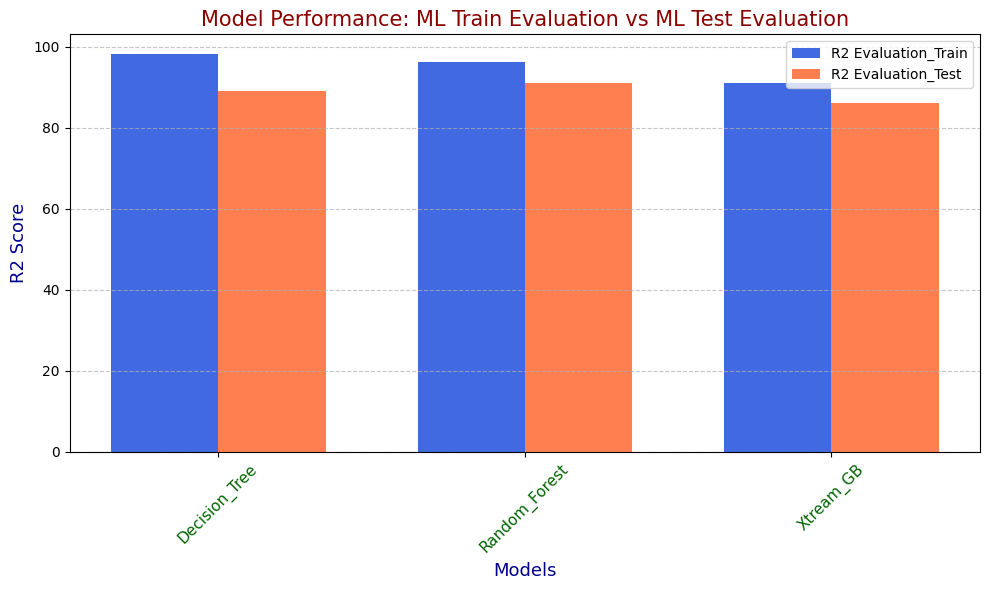

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plotting the grouped bar chart
bar_width = 0.35
index = np.arange(len(Model))

plt.bar(index, R2_Evalu_Train, width=bar_width, color='royalblue', label='R2 Evaluation_Train')
plt.bar(index + bar_width, R2_Evalu_Test, width=bar_width, color='coral', label='R2 Evaluation_Test')

# Labeling the chart
plt.xlabel('Models', fontsize=13, color='darkblue')
plt.ylabel('R2 Score', fontsize=13, color='darkblue')
plt.title('Model Performance: ML Train Evaluation vs ML Test Evaluation', fontsize=15, color='darkred')

# Adding model names
plt.xticks(index + bar_width / 2, Model, rotation=45, fontsize=11, color='darkgreen')

# Adding a legend and grid
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


**Finally Manualy Checking How well the model is Performing**

**First Check the Performance of the RandomForest Model**

In [90]:
import numpy as np

# Define Features as a 2D list where each sublist represents a set of features
Features = [[657, 524, 563, 4, 4, 0.004352, 0.000008, 0.199259],
                [3, 2, 2, 3, 0, 0.087224, 0.003039, 0.073704],
                 [222, 0, 0, 12, 0, 0.452709, 0.259097, 0.022437],
 [363, 27, 18, 6, 2, 0.013523, 0.007330, 0.199259],
 [0, 0, 0, 6, 3, 0.452709, 0.259097, 0.199259]]


# Loop through each set of features
for i, feature_set in enumerate(Features):
    # Convert the current feature set to a numpy array and reshape it
    feature_reshaped = np.array(feature_set).reshape(1, -1)
    
    # Scale the features using the scaler
    feature_scaled = scaler.transform(feature_reshaped)
    
    # Predict using the model
    prediction = Model1.predict(feature_scaled)[0]
    
    # Print the prediction
    print(f"Prediction for feature set {i + 1}: {prediction}")

Prediction for feature set 1: 0
Prediction for feature set 2: 0
Prediction for feature set 3: 1
Prediction for feature set 4: 0
Prediction for feature set 5: 2


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


**Now Lets Check the Performance of the Xtream Gradient Boosting Model**

In [91]:
import numpy as np

# Define Features as a 2D list where each sublist represents a set of features
Features = [[657, 524, 563, 4, 4, 0.004352, 0.000008, 0.199259],
                [3, 2, 2, 3, 0, 0.087224, 0.003039, 0.073704],
                 [222, 0, 0, 12, 0, 0.452709, 0.259097, 0.022437],
 [363, 27, 18, 6, 2, 0.013523, 0.007330, 0.199259],
 [0, 0, 0, 6, 3, 0.452709, 0.259097, 0.199259]]


# Loop through each set of features
for i, feature_set in enumerate(Features):
    # Convert the current feature set to a numpy array and reshape it
    feature_reshaped = np.array(feature_set).reshape(1, -1)
    
    # Scale the features using the scaler
    feature_scaled = scaler.transform(feature_reshaped)
    
    # Predict using the model
    prediction = Model2.predict(feature_scaled)[0]
    
    # Print the prediction
    print(f"Prediction for feature set {i + 1}: {prediction}")

Prediction for feature set 1: 0
Prediction for feature set 2: 0
Prediction for feature set 3: 1
Prediction for feature set 4: 0
Prediction for feature set 5: 2


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [92]:
import pickle
import pandas as pd

with open('/kaggle/input/final-evaluation/DecisionTree_model.pkl', 'rb') as f:
    Model_1 = pickle.load(f)

In [93]:
import numpy as np

# Define Features as a 2D list where each sublist represents a set of features
Features = [[657, 524, 563, 4, 4, 0.004352, 0.000008, 0.199259],
                [3, 2, 2, 3, 0, 0.087224, 0.003039, 0.073704],
                 [222, 0, 0, 12, 0, 0.452709, 0.259097, 0.022437],
 [363, 27, 18, 6, 2, 0.013523, 0.007330, 0.199259],
 [0, 0, 0, 6, 3, 0.452709, 0.259097, 0.199259]]


# Loop through each set of features
for i, feature_set in enumerate(Features):
    # Convert the current feature set to a numpy array and reshape it
    feature_reshaped = np.array(feature_set).reshape(1, -1)
    
    # Scale the features using the scaler
    feature_scaled = scaler.transform(feature_reshaped)
    
    # Predict using the model
    prediction = Model1.predict(feature_scaled)[0]
    
    # Print the prediction
    print(f"Prediction for feature set {i + 1}: {prediction}")

Prediction for feature set 1: 0
Prediction for feature set 2: 0
Prediction for feature set 3: 1
Prediction for feature set 4: 0
Prediction for feature set 5: 2


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


> ***So the all three model are Performing well Since the Random Forest and XGBoost accuracy, F1 score and the True positive score is also higer than the Decision Tree Model. We can Use This for the Future Purposes***